<a href="https://colab.research.google.com/github/te260ku/opencv-tutorial/blob/main/opencv_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from ipywidgets import interact

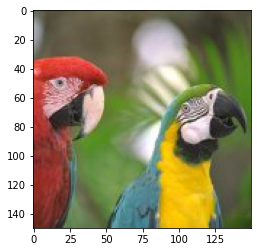

In [5]:
img_orig = io.imread('http://www.ess.ic.kanagawa-it.ac.jp/std_img/colorimage/Parrots.jpg')

plt.imshow(img_orig)
plt.show()

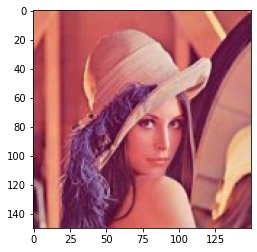

In [ ]:
img_rena = io.imread('http://www.ess.ic.kanagawa-it.ac.jp/std_img/colorimage/Lenna.jpg')

plt.imshow(img_rena)
plt.show()

In [3]:
def show_image(img, gray=False):
  if gray:
    plt.imshow(img, cmap="gray")
  else:
    plt.imshow(img)
  plt.show()

# 色空間の変換

## HSV変換
- HSV = Hue(色相)、Saturation(彩度)、Value(明度) で色を表現する
- 1次元の値で色を指定できる→特定の色を持つ物体の検出がしやすい

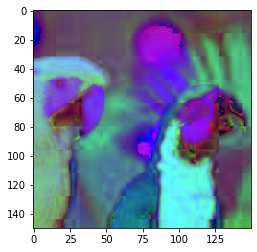

In [ ]:
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_BGR2HSV)

plt.imshow(img_hsv)
plt.show()

# 画像の閾値処理

## 単純な閾値処理
- グレースケール化→二値化

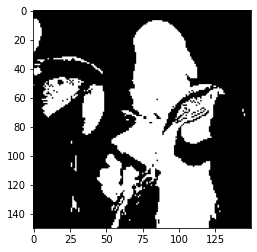

In [ ]:
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
ret, img_bin = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

plt.imshow(img_bin, cmap="gray")
plt.show()

## 大津の二値化
- 二値化における分離の閾値を自動決定する教師なし手法
- 入力画像の輝度値の分布が双峰性であると仮定
- それをクラス内分散が等しくなるように二分割するような閾値を探す

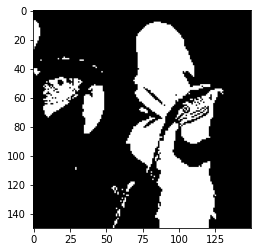

In [ ]:
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
ret, img_bin = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(img_bin, cmap="gray")
plt.show()

# 画像の平滑化
- LPFはノイズ除去や画像をぼかすために、HPFは画像中のエッジ検出に使われる
- 入力画像とカーネル(フィルタ)のconvolutionを計算
  - OpenCVには4種類のフィルターがある

### 1. 平均フィルタ

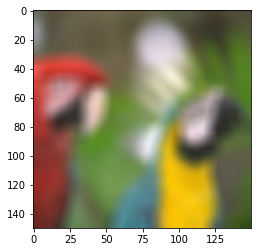

In [ ]:
img_blur = cv2.blur(img_orig, (10,10))
show_image(img_blur)

### 2. ガウシアンフィルタ
- 注目画素との距離に応じて重みを変える
- ホワイトノイズの除去に適している

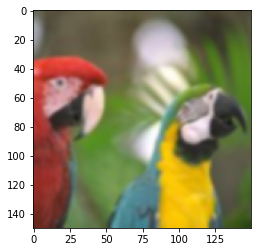

In [ ]:
img_blur_gaussian = cv2.GaussianBlur(img_orig, (5,5), 0)
show_image(img_blur_gaussian)

### 3. メディアンフィルタ
- 出力は元画像の画素値をそのまま使うので、ごま塩ノイズのような特異なノイズ除去に適している

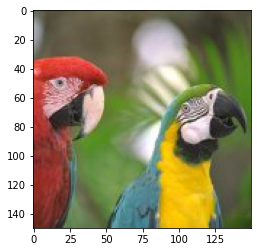

In [ ]:
img_median = cv2.medianBlur(img_orig, 5)
show_image(img_orig)

### 4. バイラテラルフィルタ
- エッジを保存したまま画像をぼかす
- 2つのガウシアンフィルタを使う
  - 1. 普通のガウシアンフィルタ(注目画素の近傍を取り込む)
  - 2. 注目画素に似た画素値を持つ画素のみを考慮してフィルタリングする 
- 体表面のモサモサが除去されている

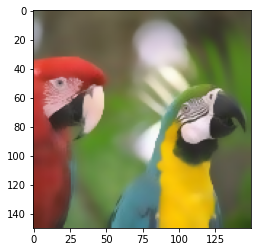

In [ ]:
img_blur_bilateraul = cv2.bilateralFilter(img_orig, 9, 75, 75)
show_image(img_blur_bilateraul)

# 画像の勾配
- Sobel, Scharr, Laplaciannoの3種類の勾配検出フィルタが使える
- 出力の型をcv2.CV_64Fにすることで正負両方のエッジを検出できる

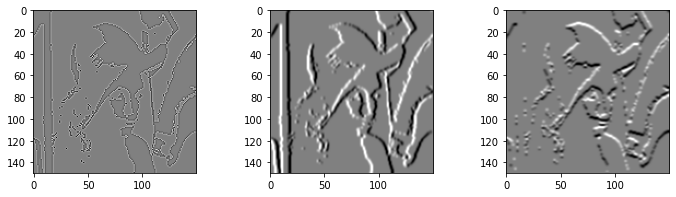

In [ ]:
img_gray = cv2.cvtColor(img_rena, cv2.COLOR_BGR2GRAY)
ret, img_bin = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
img_laplacian = cv2.Laplacian(img_bin, cv2.CV_64F)
img_sobel_x = cv2.Sobel(img_bin, cv2.CV_64F, 1, 0, ksize=5)
img_sobel_y = cv2.Sobel(img_bin, cv2.CV_64F, 0, 1, ksize=5)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(img_laplacian, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(img_sobel_x, cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(img_sobel_y, cmap="gray")
plt.show()

# Canny法によるエッジ検出
手順 
- 5x5のGaussianフィルタを使って平滑化 
- 縦方向と横方向のSobelフィルターを使って画像の輝度勾配を見つける 
- エッジと関係のない画素を取り除く 
  - 各画素に対してそれが勾配方向に対して極大値でない場合は抑制することで、細いエッジを含む二値画像を作る
- 正しいエッジとそうでないエッジを区別する 
  - maxValとminValの2つの閾値との大小関係によって正しいエッジを判別する 
  - 正しいエッジに隣接している画素も正しいエッジとして捉える

In [6]:
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

def canny(minVal, maxVal):
  img_canny = cv2.Canny(img_gray, minVal, maxVal)
  plt.imshow(img_canny, cmap="gray")
  plt.show()
  
interact(canny, minVal=(0,255,1), maxVal=(0,255,1))

interactive(children=(IntSlider(value=127, description='minVal', max=255), IntSlider(value=127, description='m…

<function __main__.canny>

# 画像ピラミッド
- 異なる解像度を持つ画像の集合を積み上げたもの
- 画像中の大きさが不明な物体を探すときや、画像のブレンディングに使う
- 行と列を1行、1列ごとに削除したものにガウシアンフィルタをかけることで、解像度を1/4にダンサンプリングする

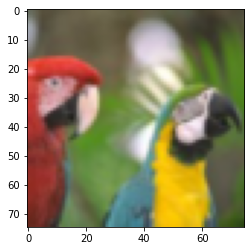

In [7]:
img_lower_reso = cv2.pyrDown(img_orig)
show_image(img_lower_reso)